Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
RMSE: 2.45
R² Score: 0.92


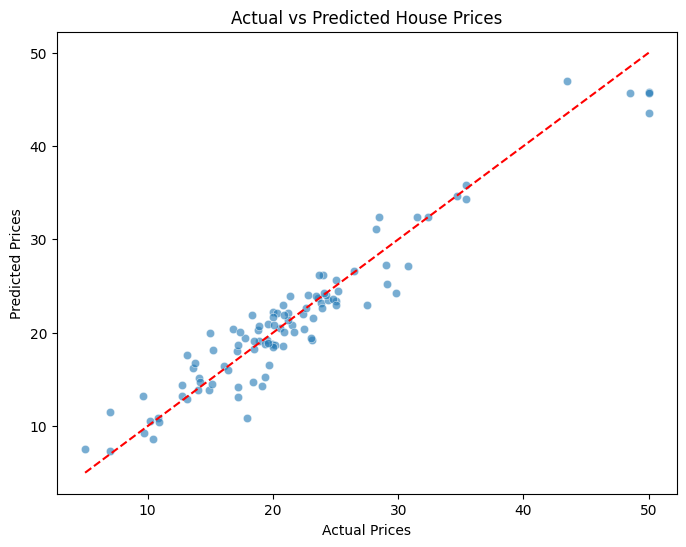

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


# Load dataset (replace with your own or load Ames dataset)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"  # Changed URL
df = pd.read_csv(url, header=None)  # Added header=None for this dataset

# Drop rows with missing target
# Update column name for SalePrice (column 13, index 12 in this dataset)
df = df.dropna(subset=[12])

# Feature Engineering: Handle missing data
# Apply median imputation for numeric columns excluding Order and PID
# Re-index columns to include a SalePrice column name
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df.columns = [*df.columns[:-1], 'SalePrice']  # Rename last column to 'SalePrice'
df = pd.get_dummies(df.select_dtypes(include=[np.number]).drop([0, 1], axis=1), drop_first=True)  # Update dropped columns to 0, 1

# Rest of the code remains the same
# ...



# Define features and target
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                    scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

grid.fit(X_train_scaled, y_train)

# Best model
best_model = grid.best_estimator_

# Predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid.best_params_}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.show()